In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import hvplot.pandas
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

ca_housing_path = "Resources/CA_Housing_Data.csv"

ca_housing_data = pd.read_csv(ca_housing_path)

ca_housing_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


# Put proximities into a list for for loop (and later for plot labels)
Ocean_Proximity = ["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]
Ocean_Proximity

# Create empty list to fill with population data (for plotting)
population_data= []

# Calculate the IQR and quantitatively determine if there are any potential outliers.
for proximity in Ocean_Proximity:

     # Locate the rows which contain the population data for each category of ocean proximity
    Population = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == proximity, "population"]
    
    quartiles = Population.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    # add subset
    population_data.append(Population)

    # Determine outliers using upper and lower bounds
    
    upper_bound = upperq + (1.5*iqr)
    lower_bound = lowerq - (1.5*iqr)

    outliers_population = Population[(Population < lower_bound) | (Population > upper_bound)]


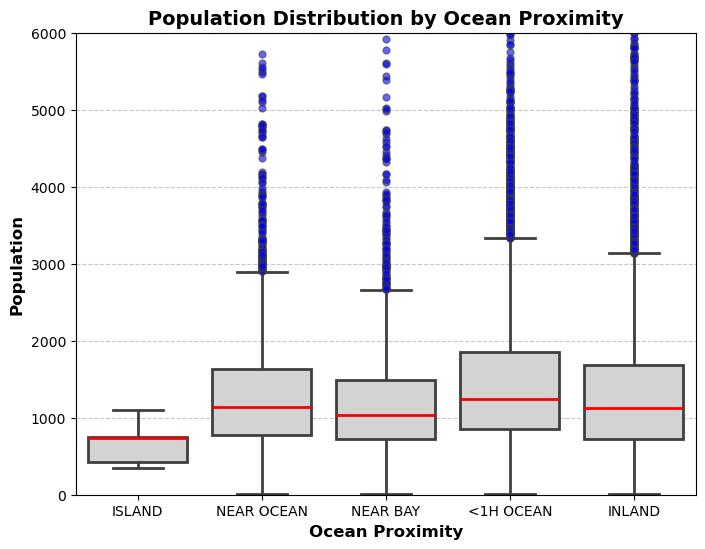

In [40]:
# Define the custom order for ocean proximity categories
custom_order = ["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]

# Set figure size
plt.figure(figsize=(8, 6))

# Create a customized boxplot with the defined x-axis order
sns.boxplot(
    x=ca_housing_data["ocean_proximity"], 
    y=ca_housing_data["population"], 
    order=custom_order,  # Apply custom order
    boxprops={'linewidth': 2, 'facecolor': 'lightgray'},  
    medianprops={'color': 'red', 'linewidth': 2},  
    whiskerprops={'linewidth': 2},  
    capprops={'linewidth': 2},  
    flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'blue', 'alpha': 0.6}  
)

# Labels and title
plt.xlabel("Ocean Proximity", fontsize=12, fontweight='bold')
plt.ylabel("Population", fontsize=12, fontweight='bold')
plt.title("Population Distribution by Ocean Proximity", fontsize=14, fontweight='bold')
plt.ylim(0, 6000)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()



This boxplot shows the distribution for the populations for the areas grouped by their proximity to the ocean. We can see that the Island areas have a significantly lower and more consistent size across all of their locations. Areas near the ocean, bay, and inland show greater variability, with some areas within those regions having very high populations, which is indcated by the outliers. The outliers suggest some highly populated areas within the near ocean, near bay, and inland categories. The median population is fairly similar across most categories, suggesting similar central tendencies.


In [41]:
household_pop_ratio = ca_housing_data.groupby("ocean_proximity").agg(total_households=("households", 'sum'), total_population=("population", 'sum')).reset_index()

household_pop_ratio['household_to_pop_ratio'] = household_pop_ratio['total_population']/household_pop_ratio['total_households']

household_pop_ratio

,ocean_proximity,total_households,total_population,household_to_pop_ratio
0,<1H OCEAN,4730118,13889374,2.936369
1,INLAND,3127759,9112744,2.913506
2,ISLAND,1383,3340,2.415040
3,NEAR BAY,1118931,2817427,2.517963
4,NEAR OCEAN,1332308,3598955,2.701294


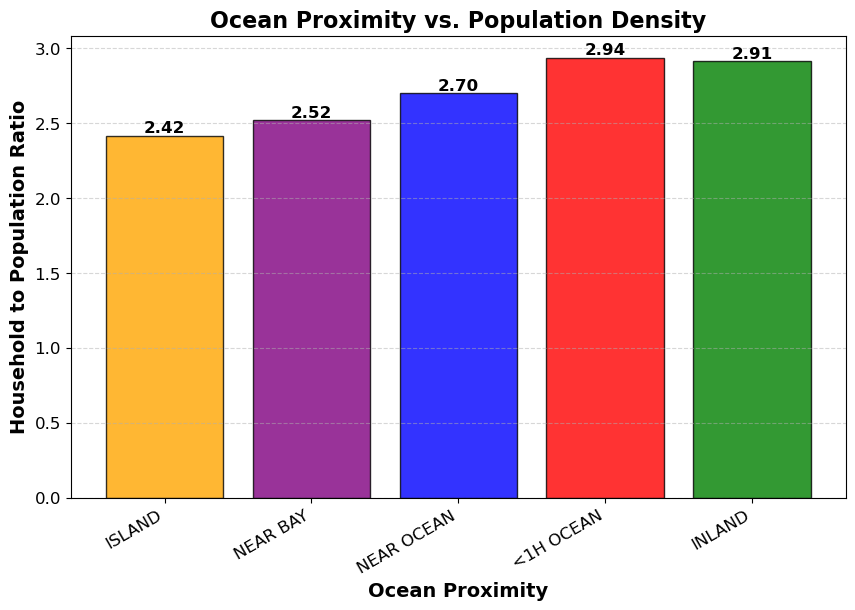

In [24]:

# Extract x and y values
x_values = household_pop_ratio["ocean_proximity"]
y_values = household_pop_ratio["household_to_pop_ratio"]

# Define the desired order for x-axis categories
desired_order = ["ISLAND", "NEAR BAY", "NEAR OCEAN", "<1H OCEAN", "INLAND"]

# Convert data into a DataFrame for easier sorting
df = pd.DataFrame({'ocean_proximity': x_values, 'household_to_pop_ratio': y_values})

# Reorder the DataFrame based on the desired category order
df['ocean_proximity'] = pd.Categorical(df['ocean_proximity'], categories=desired_order, ordered=True)
df = df.sort_values('ocean_proximity')

# Define colors for better visualization
colors = ['orange', 'purple', 'blue', 'red', 'green']

# Create the bar chart with enhancements
plt.figure(figsize=(10, 6))
bars = plt.bar(df['ocean_proximity'], df['household_to_pop_ratio'], color=colors, edgecolor='black', alpha=0.8)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add labels and title with improved font sizes
plt.xlabel('Ocean Proximity', fontsize=14, fontweight='bold')
plt.ylabel('Household to Population Ratio', fontsize=14, fontweight='bold')
plt.title("Ocean Proximity vs. Population Density", fontsize=16, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the improved plot
plt.show()


This bar chart shows the household to population ratio according to each ocean proximity group. We can see that the Island group has a household to population ratio of 2.42 people to each household and the number of people per household increases slightly as you get further away from the ocean. However, the differnce between the lowest ratio, the Island, is the greatest ratio, the group less than an hour from the ocean, is less than half a person. It does not seem like the proximity to the ocean makes a significant difference in the population density. 

y = -0.02x +4.39
The r^2-value is: 0.014169090760525757


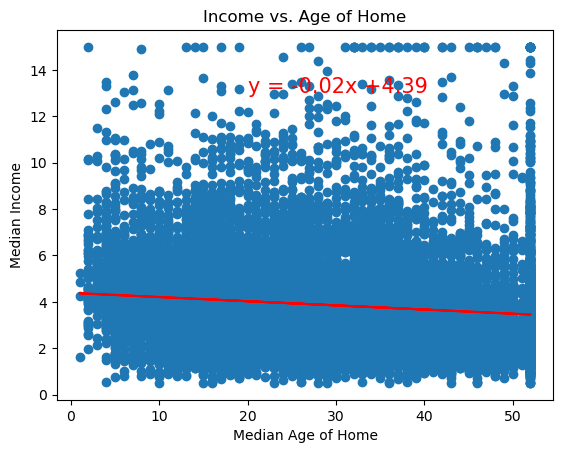

In [3]:
x_values = ca_housing_data["housing_median_age"]
y_values = ca_housing_data["median_income"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-") 

# Label plot and annotate the line equation
plt.xlabel('Median Age of Home')
plt.ylabel('Median Income')
plt.annotate(line_eq,(20,13),fontsize=15,color="red",)
plt.title(f"Income vs. Age of Home")

# Print r^2 value
print(f"The r^2-value is: {rvalue**2}")

# Show plot
plt.show()

This scatter plot and regression line comparing the age of the home to the median income shows that there is not a significant correlation between housing price and the age of the home. Additionally we can see that the correlation coefficient value is .014 which indicates there is no correlation between housing age and income. 

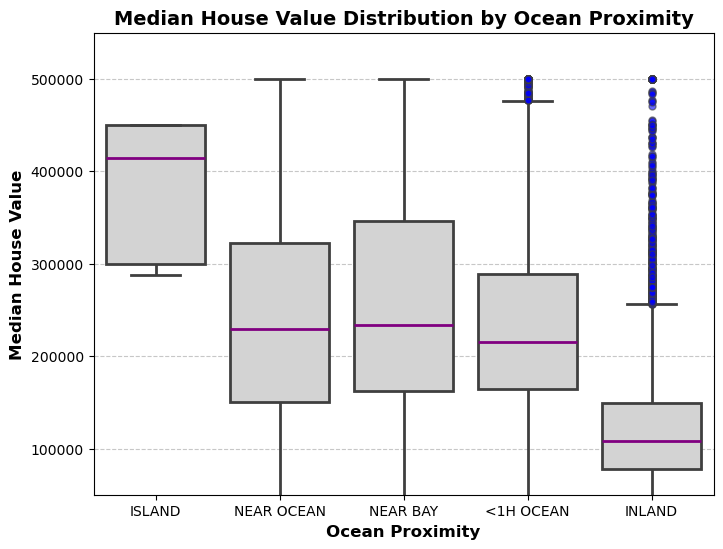

In [10]:
# Define the custom order for ocean proximity categories
custom_order = ["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]

# Set figure size
plt.figure(figsize=(8, 6))

# Create a customized boxplot with the defined x-axis order
sns.boxplot(
    x=ca_housing_data["ocean_proximity"], 
    y=ca_housing_data["median_house_value"], 
    order=custom_order,
    boxprops={'linewidth': 2, 'facecolor': 'lightgray'},  
    medianprops={'color': 'purple', 'linewidth': 2},  
    whiskerprops={'linewidth': 2},  
    capprops={'linewidth': 2},  
    flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'blue', 'alpha': 0.6}  
)

# Labels and title
plt.xlabel("Ocean Proximity", fontsize=12, fontweight='bold')
plt.ylabel("Median House Value", fontsize=12, fontweight='bold')
plt.title("Median House Value Distribution by Ocean Proximity", fontsize=14, fontweight='bold')
plt.ylim(50000, 550000)


# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

This box plot shows a significant relationship between the house value and the proximity to the ocean. The island homes are significantly more expensive with no outliers and the Near Ocean, Near Bay, and Less than an house from the Ocean properties are all similar in price but significantly less expensive than an Island home. There is a significant drop off in price when it comes to Inland homes althoght there are some outliers for the homes that are inland and less than an hour from the ocean which suggests there are some expensive areas further from the ocean as well. 